In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests

def load_image_from_github(raw_url, grayscale=False):
    response = requests.get(raw_url)

    if response.status_code != 200:
        raise ValueError(f"Failed to download image. Status code: {response.status_code}")
    image_bytes = np.frombuffer(response.content, np.uint8)

    # Decode image
    if grayscale:
        img = cv.imdecode(image_bytes, cv.IMREAD_GRAYSCALE)
    else:
        img = cv.imdecode(image_bytes, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    if img is None:
        raise ValueError("cv.imdecode failed. URL may not point to an image.")

    return img


Q1)

In [3]:
runway_url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/data/runway.png"

runway = load_image_from_github(runway_url, grayscale=True)




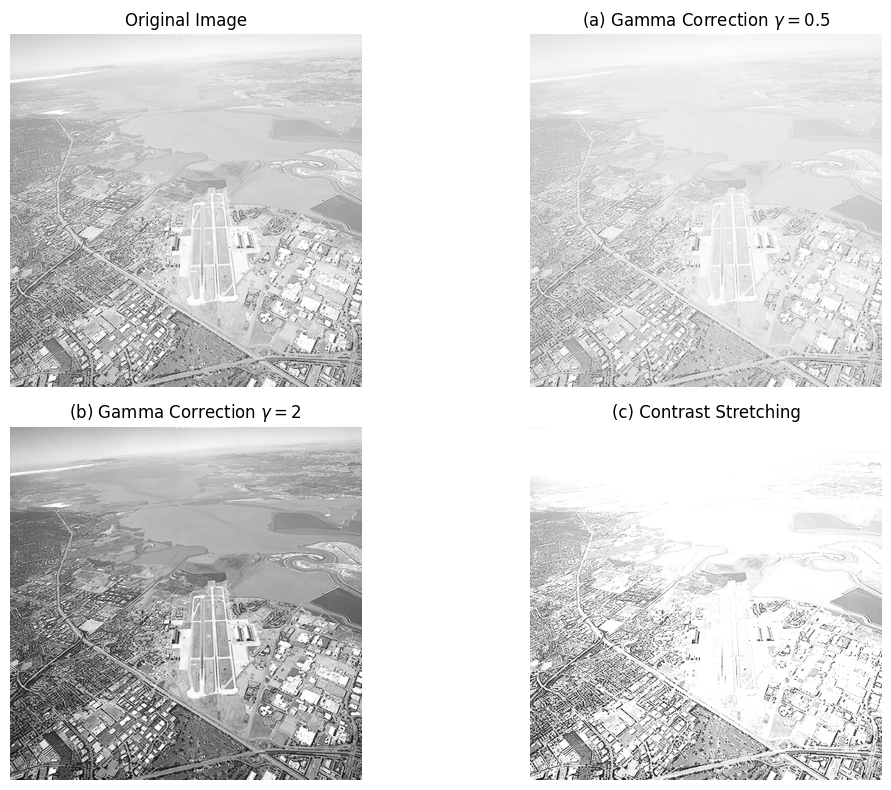

In [4]:
# Load runway image (grayscale)
img = runway.copy()

# Normalize to [0, 1]
r = img / 255.0

# (a) Gamma correction: γ = 0.5
gamma_a = 0.5
img_gamma_05 = np.uint8(np.clip(np.power(r, gamma_a) * 255, 0, 255))

# (b) Gamma correction: γ = 2.0
gamma_b = 2.0
img_gamma_2 = np.uint8(np.clip(np.power(r, gamma_b) * 255, 0, 255))

# (c) Contrast stretching
r1, r2 = 0.2, 0.8
s = np.zeros_like(r)

mask_mid = (r >= r1) & (r <= r2)
s[mask_mid] = (r[mask_mid] - r1) / (r2 - r1)
s[r > r2] = 1.0

img_contrast = np.uint8(np.clip(s * 255, 0, 255))

# Visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_gamma_05, cmap="gray")
plt.title(r"(a) Gamma Correction $\gamma=0.5$")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img_gamma_2, cmap="gray")
plt.title(r"(b) Gamma Correction $\gamma=2$")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img_contrast, cmap="gray")
plt.title("(c) Contrast Stretching")
plt.axis("off")

plt.tight_layout()
plt.show()


Q2)

In [5]:
# Load the color highlights_and_shadows.jpg for Question 2
gamma_color_url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/data/highlights_and_shadows.jpg"

color_img = load_image_from_github(gamma_color_url, grayscale=False)


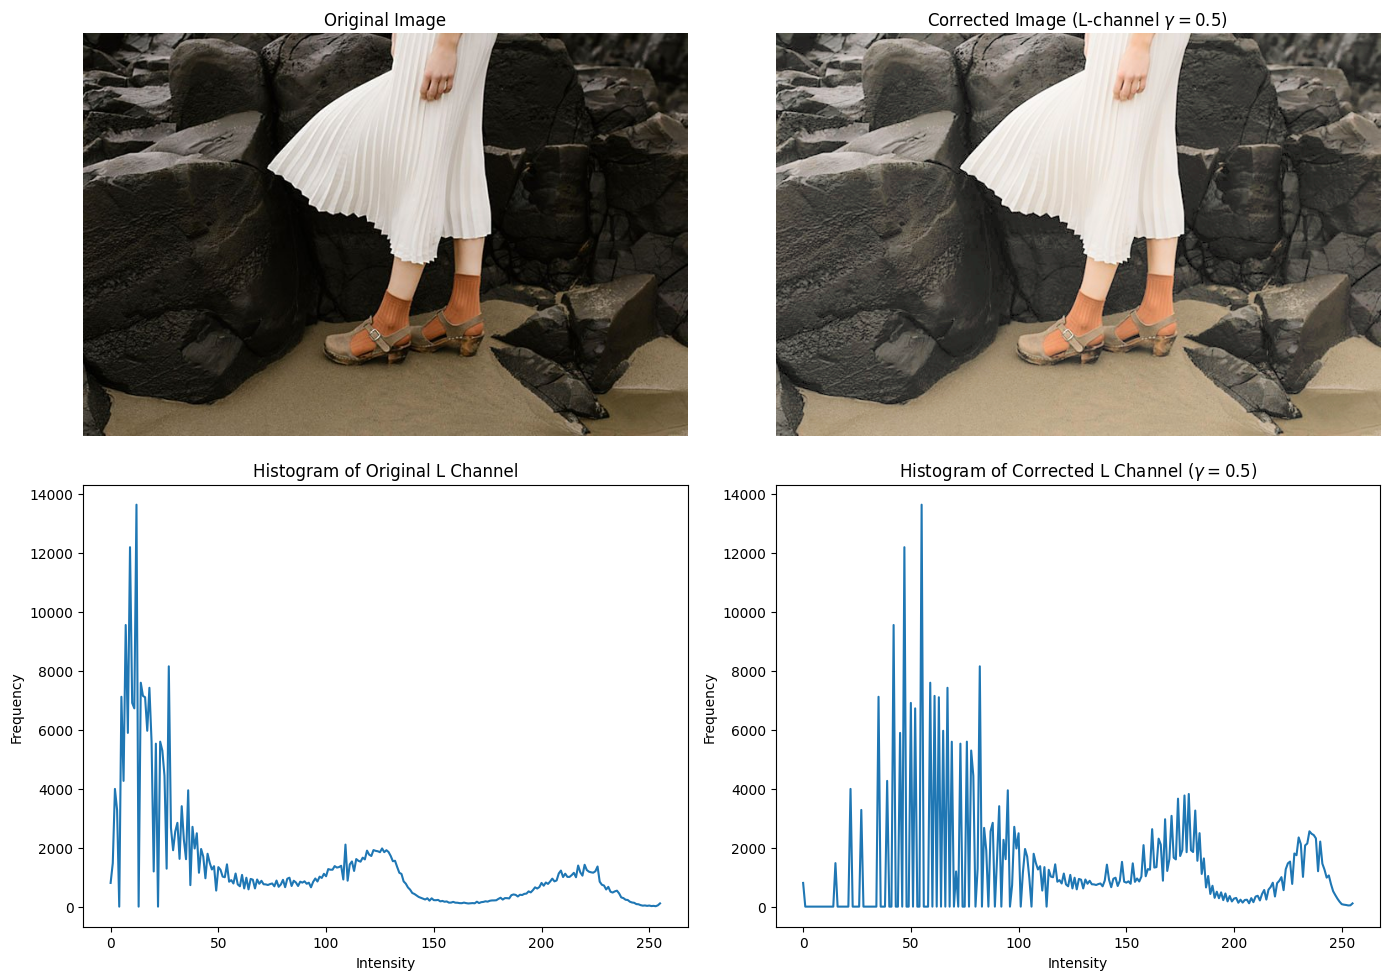

In [6]:
gamma_value = 0.5

# Convert RGB → LAB
img_lab = cv.cvtColor(color_img, cv.COLOR_RGB2LAB)
L, a, b = cv.split(img_lab)

# Gamma correction on L channel
L_norm = L / 255.0
L_gamma = np.uint8(np.clip(np.power(L_norm, gamma_value) * 255, 0, 255))

# Merge channels and convert back to RGB
lab_corrected = cv.merge((L_gamma, a, b))
img_corrected = cv.cvtColor(lab_corrected, cv.COLOR_LAB2RGB)

# Histograms
hist_L_orig = cv.calcHist([L], [0], None, [256], [0, 256])
hist_L_corr = cv.calcHist([L_gamma], [0], None, [256], [0, 256])

# Visualization
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.imshow(color_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_corrected)
plt.title(rf"Corrected Image (L-channel $\gamma={gamma_value}$)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.plot(hist_L_orig)
plt.title("Histogram of Original L Channel")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.plot(hist_L_corr)
plt.title(rf"Histogram of Corrected L Channel ($\gamma={gamma_value}$)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Q3)

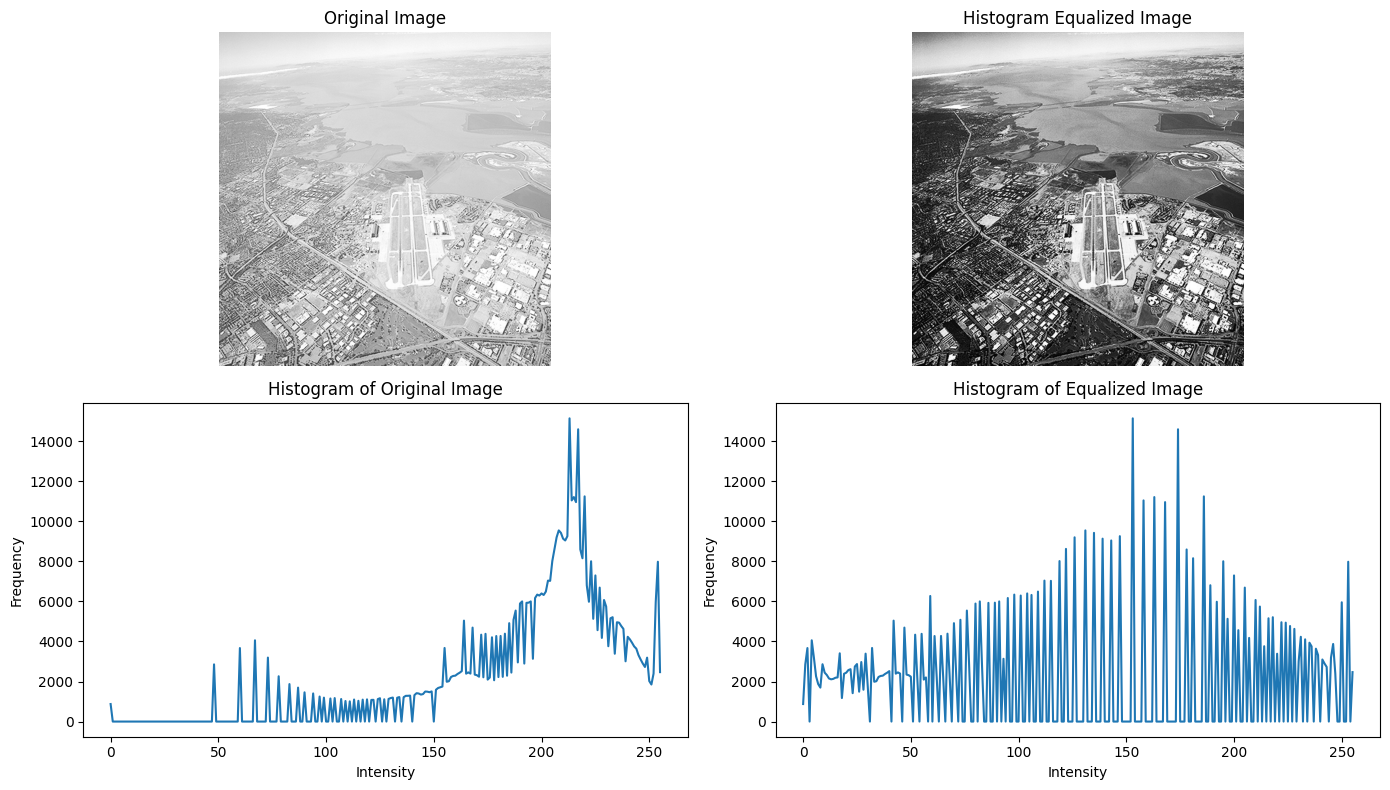

In [8]:
# Use the runway image
img = runway.copy()

# Manual histogram equalization function
def manual_hist_equalization(img):
    # Compute histogram
    hist = np.bincount(img.flatten(), minlength=256)

    # Compute cumulative distribution function (CDF)
    cdf = hist.cumsum()

    # Normalize CDF to [0, 255]
    cdf_normalized = (cdf - cdf.min()) / (cdf.max() - cdf.min())
    cdf_scaled = np.uint8(cdf_normalized * 255)

    # Map original image through CDF
    img_eq = cdf_scaled[img]

    return img_eq


# Apply histogram equalization to runway image
img_eq = manual_hist_equalization(runway)

# Histograms
hist_original = np.bincount(runway.flatten(), minlength=256)
hist_equalized = np.bincount(img_eq.flatten(), minlength=256)

# Visualization
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.imshow(runway, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_eq, cmap="gray")
plt.title("Histogram Equalized Image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.plot(hist_original)
plt.title("Histogram of Original Image")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.plot(hist_equalized)
plt.title("Histogram of Equalized Image")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Q4)

Otsu Threshold Value: 101.0


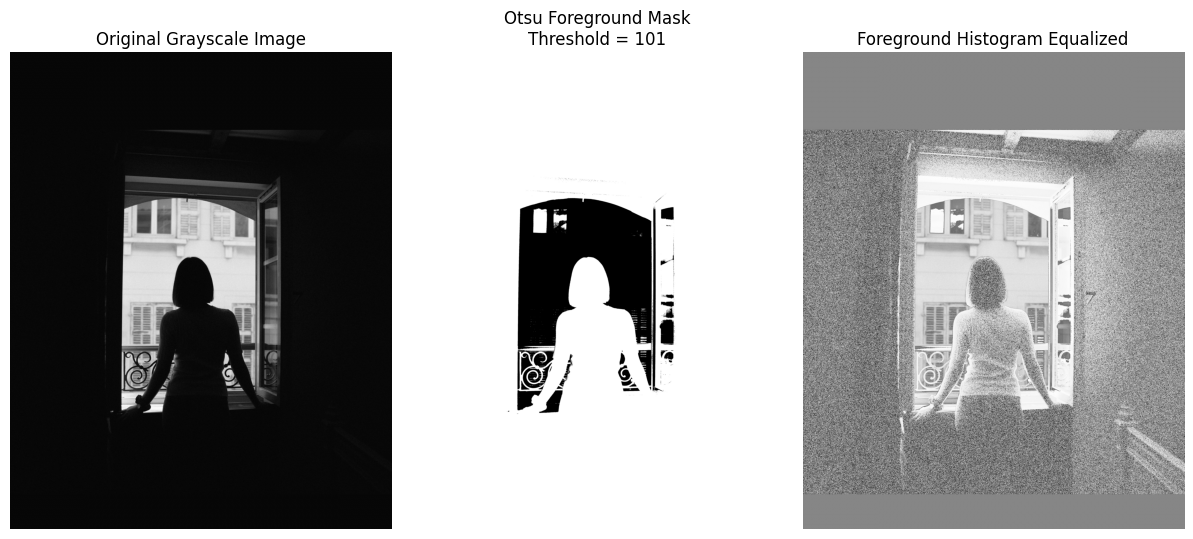

In [7]:
# Load image from GitHub and convert to grayscale
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/data/looking_out.jpg"

img_rgb = load_image_from_github(url, grayscale=False)
img = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)

# (a) Otsu Thresholding (foreground = woman + room)
otsu_threshold, mask = cv.threshold(
    img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU
)

print("Otsu Threshold Value:", otsu_threshold)

# (b) Histogram Equalization on Foreground Only
foreground_pixels = img[mask == 255]

hist = np.bincount(foreground_pixels, minlength=256)
cdf = hist.cumsum()

cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')

img_equalized = img.copy()
img_equalized[mask == 255] = cdf_final[img[mask == 255]]

# Visualization
plt.figure(figsize=(16, 6))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap="gray")
plt.title(f"Otsu Foreground Mask\nThreshold = {otsu_threshold:.0f}")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(img_equalized, cmap="gray")
plt.title("Foreground Histogram Equalized")
plt.axis("off")

plt.tight_layout()
plt.show()


Q5)